In [1]:
import pygplates
from gprm import PointDistributionOnSphere
from gprm.datasets import Reconstructions
import pygmt
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString, Polygon, Point


%load_ext autoreload
%autoreload 2


In [2]:
M2019 = Reconstructions.fetch_Muller2019()


In [3]:
topological_model = pygplates.TopologicalModel(
            M2019.dynamic_polygons,
            M2019.rotation_model,
            # Enable strain rate clamping to better control crustal stretching factors...
            default_resolve_topology_parameters=pygplates.ResolveTopologyParameters(enable_strain_rate_clamping=True))


In [4]:
features = pygplates.FeatureCollection('/Users/simon/GIT/pygplates-paleo/strat/tibet_geochem.geojson')

#gdf = gpd.read_file('/Users/simon/GIT/pygplates-paleo/strat/tibet_geochem.geojson')


#gdf = gpd.read_file('/Users/simon/Downloads/Evenick/Evenick, 2021, Global Basins.shp')
gdf = gpd.read_file('/Users/simon/GIT/gpdata/reconstructions/PEHRSSON2015/PlatePolygons.shp')
#gdf['FROMAGE'] = 

#for feature in features:
#    print(feature.get_shapefile_attributes())
#    break


In [5]:
def deform_geometries(gdf, topological_model, reconstruction_time, 
                      initial_time=0, final_time=None,
                      reconstruct_points_as_features=False,
                      deactivate_points_that_fall_outside_a_network = True):
    
    # Given a geodataframe, will reconstruct using a topological model to a given reconstruction time
    
    # TODO adapt for polylines and polygons
    
    # Do this to detect cases with a mixture of types? (and tell user this isn't supported?)
    # gdf.geom_type.unique()
    
    if not final_time:
        final_time = reconstruction_time
    
    #reconstructed_features_list = []
    
    # Preprocessing:
    gdf = gdf[gdf.geometry.is_valid]   # remove invalid geometries
    if all([item in gdf.columns for item in ['FROMAGE','TOAGE']]):
        gdf = gdf[(gdf.FROMAGE>=reconstruction_time) & (gdf.TOAGE<=reconstruction_time)]   # select points valid at reconstruction time
    gdf = gdf.explode()   # multipart to singlepart
    gdf.reset_index(inplace=True)   # reset index
    
     
    # It is quicker to reconstruct features with just one call to the topological model, but we need 
    # to check that this is possible (and desired) for the input dataframe
    if len(gdf.geom_type.unique())==1 and gdf.geom_type.unique()[0]=='Point' and not reconstruct_points_as_features:  

        
        
        # Should work for points, but for polygon/polyline need to iterate over each feature 
        geometry_points = [(lat,lon) for lat,lon in zip(gdf.geometry.y,gdf.geometry.x)]

        time_spans = topological_model.reconstruct_geometry(
                        geometry_points,
                        initial_time=initial_time,
                        oldest_time=final_time,
                        youngest_time=initial_time,
                        # All our points are on continental crust so we keep them active through time (ie, never deactivate them)...
                        deactivate_points = None) #pygplates.ReconstructedGeometryTimeSpan.DefaultDeactivatePoints(
                            #deactivate_points_that_fall_outside_a_network = deactivate_points_that_fall_outside_a_network))

        reconstructed_points = time_spans.get_geometry_points(reconstruction_time, return_inactive_points=True)
        
        # TODO for cases where this could lead to an array of inconsistent length - maybe should allow points to be 'None'??
        valid_index = [reconstructed_point is not None for reconstructed_point in reconstructed_points]
        pts = list(zip(*[reconstructed_point.to_lat_lon() for reconstructed_point in reconstructed_points if reconstructed_point is not None]))

        reconstructed_gdf = gdf.iloc[valid_index]
        reconstructed_gdf = reconstructed_gdf.set_geometry(gpd.points_from_xy(pts[1], pts[0]))

    # For all polylines and polygons, and points treated as individual features, we reconstruct by iterating over features
    else:
        
        reconstructed_gdf = gdf.copy()  #gpd.GeoDataFrame(columns=gdf.columns)
        
        for i,feature in gdf.iterrows():
            
            # This won't work for points
            #print(feature)
            if feature.geometry.geom_type in ['LineString']:
                geometry_points = [(lat,lon) for lat,lon in zip(feature.geometry.xy[1], feature.geometry.xy[0])]
            elif feature.geometry.geom_type in ['Polygon']:
                geometry_points = [(lat,lon) for lat,lon in zip(feature.geometry.exterior.coords.xy[1], 
                                                                feature.geometry.exterior.coords.xy[0])]
            
            # TODO add option to tesselate features??

            time_spans = topological_model.reconstruct_geometry(
                            geometry_points,
                            initial_time=initial_time,
                            oldest_time=final_time,
                            youngest_time=initial_time,
                            # All our points are on continental crust so we keep them active through time (ie, never deactivate them)...
                            deactivate_points = None) #pygplates.ReconstructedGeometryTimeSpan.DefaultDeactivatePoints(
                                #deactivate_points_that_fall_outside_a_network = deactivate_points_that_fall_outside_a_network))

            reconstructed_points = time_spans.get_geometry_points(reconstruction_time, return_inactive_points=True)

            # TODO for cases where this could lead to an array of inconsistent length - maybe should allow points to be 'None'??
            valid_index = [reconstructed_point is not None for reconstructed_point in reconstructed_points]
            pts = list(zip(*[reconstructed_point.to_lat_lon() for reconstructed_point in reconstructed_points if reconstructed_point is not None]))

            # TODO put something in here to deal with cases where the whole geometry has become invalid
            # 
            if feature.geometry.geom_type in ['LineString']:
                geom = LineString([tuple(coord) for coord in zip(pts[1], pts[0])])
            elif feature.geometry.geom_type in ['Polygon']:
                geom = Polygon([tuple(coord) for coord in zip(pts[1], pts[0])])
            #else:
            #    geom = Point(tuple(pts[1], pts[0]))
            reconstructed_gdf.loc[i, 'geometry'] = geom
            
               
            #geometry = gdf.iloc[valid_index]
            #reconstructed_gdf = reconstructed_gdf.set_geometry(gpd.points_from_xy(pts[1], pts[0]))

       
    return reconstructed_gdf
    
def deform_point_sequence():
    
    
    

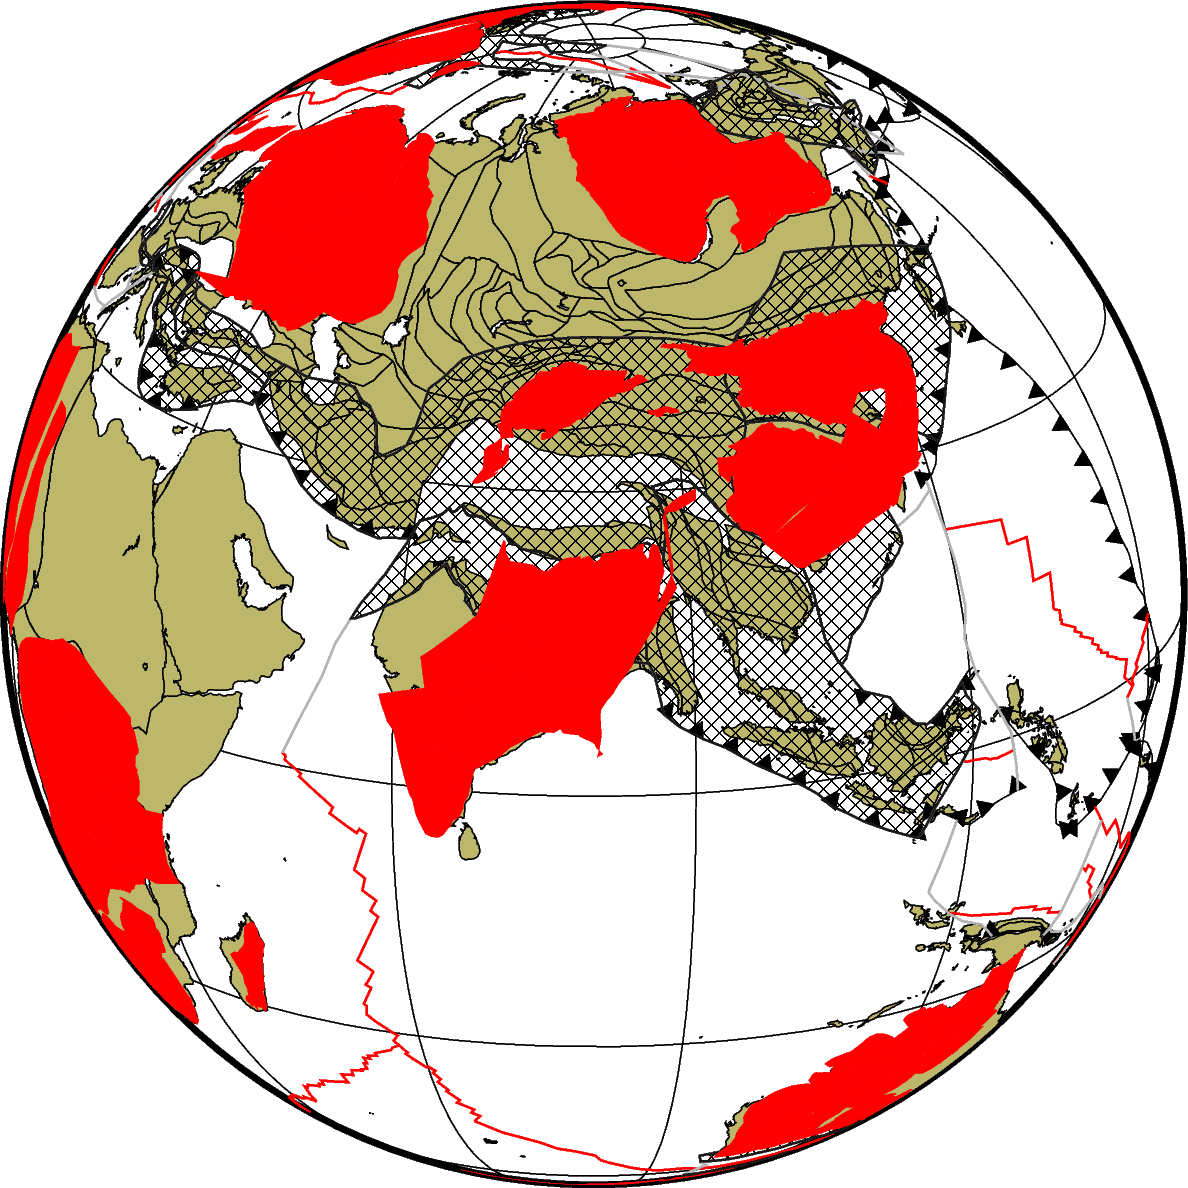

In [11]:
reconstruction_time = 35.

result = deform_geometries(gdf, topological_model, reconstruction_time,
                           deactivate_points_that_fall_outside_a_network=None)

reconstructed_plates = M2019.plate_snapshot(reconstruction_time)
reconstructed_continents = M2019.polygon_snapshot('coastlines', reconstruction_time)

fig = pygmt.Figure()
fig.basemap(region='d', projection='G80/20/10c', frame='afg')
#fig.coast(land='gray')
reconstructed_continents.plot(fig, color='darkkhaki')
reconstructed_plates.plot_subduction_zones(fig)
reconstructed_plates.plot_mid_ocean_ridges(fig)
reconstructed_plates.plot_other_boundaries(fig)
reconstructed_plates.plot_deformation_zones(fig)

#fig.plot(x=gdf.geometry.x, y=gdf.geometry.y, style='c0.1c')
#fig.plot(x=result.geometry.x, y=result.geometry.y, style='c0.1c', color='red')

result.to_file('tmp.gmt', driver='OGR_GMT')
fig.plot(data='tmp.gmt', color='red')
fig.show(width=800)


In [ ]:
result
#for i,row in gdf.iterrows():
    
#    print(row.geometry.exterior)


In [ ]:
from gprm.utils.create_gpml import gdf2gpml, gpml2gdf

fc = pygplates.FeatureCollection('/Users/simon/GIT/gpdata/reconstructions/MERDITH/shapes_continents_Merdith_et_al.gpml')

g = gpml2gdf(fc)

g.plot()


In [ ]:
ft = gdf2gpml(gdf)

ft

In [8]:
import fiona
fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'rw',
 'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'rw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'GPSTrackMaker': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'rw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r',
 'TopoJSON': 'r'}